In [79]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchvision 
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

In [103]:
from torchvision.models import vgg16

pretrained_model = vgg16(pretrained=True)
pretrained_model.eval()
pretrained_model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/Carlos/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [104]:
feature_extractor = pretrained_model.features

In [139]:
train_dir = './specgrams/TRAIN'
test_dir = './specgrams/TEST'
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((112,112)),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0,1),
    ])

batch_size = 64

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [140]:
train_dir = './specgrams/TRAIN'
validation_dir = './specgrams/TEST'

def extract_features(directory):
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((112,112)), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    dataset = torchvision.datasets.ImageFolder(directory, transform=transform)
    batch_size = 100
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = np.zeros(shape=(len(dataset), 512, 3, 3))
    labels = np.zeros(shape=(len(dataset),))
    with torch.no_grad():
        for i, (inputs_batch, labels_batch) in enumerate(loader):
            inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device)
            features_batch = feature_extractor(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch.cpu().numpy()
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch.cpu().numpy()

    return features, labels

train_features, train_labels = extract_features(train_dir)
validation_features, validation_labels = extract_features(validation_dir)

In [141]:
train_features = np.reshape(train_features, (-1, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (-1, 3 * 3 * 512))

In [142]:
feature_classifier = nn.Sequential(
    nn.Linear(3*3*512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

feature_classifier.to(device)

Sequential(
  (0): Linear(in_features=4608, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=1, bias=True)
  (4): Sigmoid()
)

In [143]:
optimizer = optim.Adam(feature_classifier.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [144]:
from torch.utils.data import TensorDataset

batch_size = 64
train_features_dataset = TensorDataset(torch.tensor(train_features), torch.tensor(train_labels))
train_features_loader = DataLoader(train_features_dataset, batch_size=batch_size, shuffle=True)

val_features_dataset = TensorDataset(torch.tensor(validation_features), torch.tensor(validation_labels))
val_features_loader = DataLoader(val_features_dataset, batch_size=batch_size, shuffle=False)

In [145]:
epochs = 10
train_accuracies, train_losses, val_accuracies, val_losses = train_model(feature_classifier, optimizer, loss_fn, train_features_loader, val_features_loader, epochs)










  0%|          | 0/11 [00:00<?, ? batches/s]








[TRAIN] Epoch 1/10:   0%|          | 0/11 [00:00<?, ? batches/s]








[TRAIN] Epoch 1/10:   0%|          | 0/11 [00:00<?, ? batches/s, accuracy=0.406, loss=0.718]








[TRAIN] Epoch 1/10:   0%|          | 0/11 [00:00<?, ? batches/s, accuracy=0.406, loss=0.718]








[TRAIN] Epoch 1/10:   0%|          | 0/11 [00:00<?, ? batches/s, accuracy=0.477, loss=0.676]








[TRAIN] Epoch 1/10:  18%|█▊        | 2/11 [00:00<00:00, 12.87 batches/s, accuracy=0.477, loss=0.676]








[TRAIN] Epoch 1/10:  18%|█▊        | 2/11 [00:00<00:00, 12.87 batches/s, accuracy=0.477, loss=0.676]








[TRAIN] Epoch 1/10:  18%|█▊        | 2/11 [00:00<00:00, 12.87 batches/s, accuracy=0.521, loss=0.698]








[TRAIN] Epoch 1/10:  18%|█▊        | 2/11 [00:00<00:00, 12.87 batches/s, accuracy=0.521, loss=0.698]








[TRAIN] Epoch 1/10:  18%|█▊        | 2/11 [00:00<00:00, 12.87 batches/s, accuracy=0.566, loss=0.657]








[TRAIN] Epoch 1/1

[TRAIN] Epoch 2/10:  91%|█████████ | 10/11 [00:00<00:00, 25.95 batches/s, accuracy=0.912, loss=0.252]








[TRAIN] Epoch 2/10:  91%|█████████ | 10/11 [00:00<00:00, 25.95 batches/s, accuracy=0.912, loss=0.252]








[TRAIN] Epoch 2/10:  91%|█████████ | 10/11 [00:00<00:00, 25.95 batches/s, accuracy=0.914, loss=0.251]








[TRAIN] Epoch 2/10: 100%|██████████| 11/11 [00:00<00:00, 24.59 batches/s, accuracy=0.914, loss=0.251]








  0%|          | 0/5 [00:00<?, ? batches/s]








[VAL] Epoch 2/10:   0%|          | 0/5 [00:00<?, ? batches/s]








[VAL] Epoch 2/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.844, loss=0.398]








[VAL] Epoch 2/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.844, loss=0.398]








[VAL] Epoch 2/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.914, loss=0.266]








[VAL] Epoch 2/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.914, loss=0.266]








[VAL] Epoch 2/10:   0%|          | 0/5 [00:00<

[TRAIN] Epoch 4/10:  18%|█▊        | 2/11 [00:00<00:00, 18.73 batches/s, accuracy=0.958, loss=0.127]








[TRAIN] Epoch 4/10:  18%|█▊        | 2/11 [00:00<00:00, 18.73 batches/s, accuracy=0.961, loss=0.12] 








[TRAIN] Epoch 4/10:  36%|███▋      | 4/11 [00:00<00:00, 18.48 batches/s, accuracy=0.961, loss=0.12]








[TRAIN] Epoch 4/10:  36%|███▋      | 4/11 [00:00<00:00, 18.48 batches/s, accuracy=0.961, loss=0.12]








[TRAIN] Epoch 4/10:  36%|███▋      | 4/11 [00:00<00:00, 18.48 batches/s, accuracy=0.963, loss=0.122]








[TRAIN] Epoch 4/10:  36%|███▋      | 4/11 [00:00<00:00, 18.48 batches/s, accuracy=0.963, loss=0.122]








[TRAIN] Epoch 4/10:  36%|███▋      | 4/11 [00:00<00:00, 18.48 batches/s, accuracy=0.969, loss=0.116]








[TRAIN] Epoch 4/10:  55%|█████▍    | 6/11 [00:00<00:00, 18.81 batches/s, accuracy=0.969, loss=0.116]








[TRAIN] Epoch 4/10:  55%|█████▍    | 6/11 [00:00<00:00, 18.81 batches/s, accuracy=0.969, loss=0.116]








[TRAIN] Epoch 4/10:  

  0%|          | 0/5 [00:00<?, ? batches/s]








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s]








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.875, loss=0.235]








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.875, loss=0.235]








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.93, loss=0.159] 








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.93, loss=0.159]








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.906, loss=0.234]








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.906, loss=0.234]








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.891, loss=0.261]








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.891, loss=0.261]








[VAL] Epoch 5/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.895, loss=0.266]







[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:00<00:00, 15.26 batches/s, accuracy=0.984, loss=0.0471]








[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:00<00:00, 15.26 batches/s, accuracy=0.984, loss=0.0471]








[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:00<00:00, 15.26 batches/s, accuracy=0.978, loss=0.0554]








[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:00<00:00, 15.26 batches/s, accuracy=0.978, loss=0.0554]








[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:00<00:00, 15.26 batches/s, accuracy=0.982, loss=0.0502]








[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:00<00:00, 15.26 batches/s, accuracy=0.982, loss=0.0502]








[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:00<00:00, 15.26 batches/s, accuracy=0.984, loss=0.0471]








[TRAIN] Epoch 7/10:  64%|██████▎   | 7/11 [00:00<00:00, 17.52 batches/s, accuracy=0.984, loss=0.0471]








[TRAIN] Epoch 7/10:  64%|██████▎   | 7/11 [00:00<00:00, 17.52 batches/s, accuracy=0.984, loss=0.0471]








[TRAIN] Ep

[VAL] Epoch 8/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.914, loss=0.235]








[VAL] Epoch 8/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.914, loss=0.235]








[VAL] Epoch 8/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.911, loss=0.289]








[VAL] Epoch 8/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.911, loss=0.289]








[VAL] Epoch 8/10:   0%|          | 0/5 [00:00<?, ? batches/s, accuracy=0.902, loss=0.279]








[VAL] Epoch 8/10:  80%|████████  | 4/5 [00:00<00:00, 35.21 batches/s, accuracy=0.902, loss=0.279]








[VAL] Epoch 8/10:  80%|████████  | 4/5 [00:00<00:00, 35.21 batches/s, accuracy=0.902, loss=0.279]








[VAL] Epoch 8/10:  80%|████████  | 4/5 [00:00<00:00, 35.21 batches/s, accuracy=0.905, loss=0.277]








[VAL] Epoch 8/10: 100%|██████████| 5/5 [00:00<00:00, 31.19 batches/s, accuracy=0.905, loss=0.277]








  0%|          | 0/11 [00:00<?, ? batches/s]








[TRAIN] Epoch 9/10:   0%|        

[TRAIN] Epoch 10/10:  55%|█████▍    | 6/11 [00:00<00:00, 24.32 batches/s, accuracy=0.997, loss=0.0195]








[TRAIN] Epoch 10/10:  55%|█████▍    | 6/11 [00:00<00:00, 24.32 batches/s, accuracy=0.997, loss=0.0195]








[TRAIN] Epoch 10/10:  55%|█████▍    | 6/11 [00:00<00:00, 24.32 batches/s, accuracy=0.993, loss=0.0232]








[TRAIN] Epoch 10/10:  55%|█████▍    | 6/11 [00:00<00:00, 24.32 batches/s, accuracy=0.993, loss=0.0232]








[TRAIN] Epoch 10/10:  55%|█████▍    | 6/11 [00:00<00:00, 24.32 batches/s, accuracy=0.994, loss=0.0221]








[TRAIN] Epoch 10/10:  55%|█████▍    | 6/11 [00:00<00:00, 24.32 batches/s, accuracy=0.994, loss=0.0221]








[TRAIN] Epoch 10/10:  55%|█████▍    | 6/11 [00:00<00:00, 24.32 batches/s, accuracy=0.991, loss=0.0259]








[TRAIN] Epoch 10/10:  82%|████████▏ | 9/11 [00:00<00:00, 25.21 batches/s, accuracy=0.991, loss=0.0259]








[TRAIN] Epoch 10/10:  82%|████████▏ | 9/11 [00:00<00:00, 25.21 batches/s, accuracy=0.991, loss=0.0259]








[

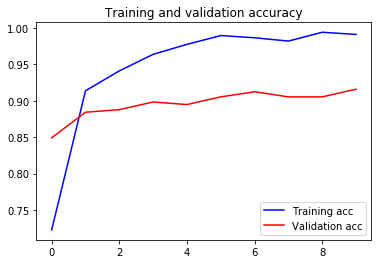

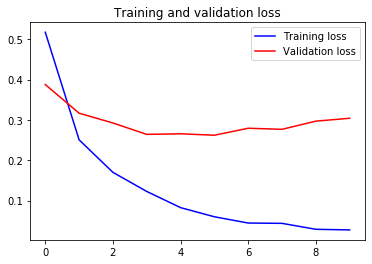

In [146]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [147]:
pretrained_model = vgg16(pretrained=True)
pretrained_model.to(device)
feature_extractor = pretrained_model.features
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [148]:
for layer in feature_extractor[:24]:  # Freeze layers 0 to 23
    for param in layer.parameters():
        param.requires_grad = False

for layer in feature_extractor[24:]:  # Train layers 24 to 30
    for param in layer.parameters():
        param.requires_grad = True

In [149]:
model = nn.Sequential(
    feature_extractor,
    nn.Flatten(),
    feature_classifier
)

model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [150]:
train_dir = './specgrams/TRAIN'
test_dir = './specgrams/TEST'
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((112,112)),
    #torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

batch_size = 64

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [151]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()

In [152]:
epochs = 10
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs)










  0%|          | 0/11 [00:00<?, ? batches/s]








[TRAIN] Epoch 1/10:   0%|          | 0/11 [00:00<?, ? batches/s]








[TRAIN] Epoch 1/10:   0%|          | 0/11 [00:13<?, ? batches/s, accuracy=0.859, loss=0.498]








[TRAIN] Epoch 1/10:   9%|▉         | 1/11 [00:13<02:14, 13.40s/ batches, accuracy=0.859, loss=0.498]








[TRAIN] Epoch 1/10:   9%|▉         | 1/11 [00:13<02:14, 13.40s/ batches, accuracy=0.859, loss=0.498]








[TRAIN] Epoch 1/10:   9%|▉         | 1/11 [00:26<02:14, 13.40s/ batches, accuracy=0.898, loss=0.34] 








[TRAIN] Epoch 1/10:  18%|█▊        | 2/11 [00:26<02:00, 13.37s/ batches, accuracy=0.898, loss=0.34]








[TRAIN] Epoch 1/10:  18%|█▊        | 2/11 [00:27<02:00, 13.37s/ batches, accuracy=0.898, loss=0.34]








[TRAIN] Epoch 1/10:  18%|█▊        | 2/11 [00:40<02:00, 13.37s/ batches, accuracy=0.911, loss=0.318]








[TRAIN] Epoch 1/10:  27%|██▋       | 3/11 [00:40<01:49, 13.65s/ batches, accuracy=0.911, loss=0.318]








[TR

[TRAIN] Epoch 2/10:  36%|███▋      | 4/11 [00:42<01:14, 10.64s/ batches, accuracy=0.988, loss=0.0253]








[TRAIN] Epoch 2/10:  36%|███▋      | 4/11 [00:43<01:14, 10.64s/ batches, accuracy=0.988, loss=0.0253]








[TRAIN] Epoch 2/10:  36%|███▋      | 4/11 [00:55<01:14, 10.64s/ batches, accuracy=0.988, loss=0.0265]








[TRAIN] Epoch 2/10:  45%|████▌     | 5/11 [00:55<01:07, 11.20s/ batches, accuracy=0.988, loss=0.0265]








[TRAIN] Epoch 2/10:  45%|████▌     | 5/11 [00:55<01:07, 11.20s/ batches, accuracy=0.988, loss=0.0265]








[TRAIN] Epoch 2/10:  45%|████▌     | 5/11 [01:06<01:07, 11.20s/ batches, accuracy=0.987, loss=0.0292]








[TRAIN] Epoch 2/10:  55%|█████▍    | 6/11 [01:06<00:55, 11.17s/ batches, accuracy=0.987, loss=0.0292]








[TRAIN] Epoch 2/10:  55%|█████▍    | 6/11 [01:06<00:55, 11.17s/ batches, accuracy=0.987, loss=0.0292]








[TRAIN] Epoch 2/10:  55%|█████▍    | 6/11 [01:16<00:55, 11.17s/ batches, accuracy=0.987, loss=0.0321]








[TRAIN] Ep

[TRAIN] Epoch 3/10:  64%|██████▎   | 7/11 [01:18<00:38,  9.64s/ batches, accuracy=0.994, loss=0.0238]








[TRAIN] Epoch 3/10:  73%|███████▎  | 8/11 [01:18<00:28,  9.57s/ batches, accuracy=0.994, loss=0.0238]








[TRAIN] Epoch 3/10:  73%|███████▎  | 8/11 [01:18<00:28,  9.57s/ batches, accuracy=0.994, loss=0.0238]








[TRAIN] Epoch 3/10:  73%|███████▎  | 8/11 [01:28<00:28,  9.57s/ batches, accuracy=0.995, loss=0.022] 








[TRAIN] Epoch 3/10:  82%|████████▏ | 9/11 [01:28<00:19,  9.53s/ batches, accuracy=0.995, loss=0.022]








[TRAIN] Epoch 3/10:  82%|████████▏ | 9/11 [01:28<00:19,  9.53s/ batches, accuracy=0.995, loss=0.022]








[TRAIN] Epoch 3/10:  82%|████████▏ | 9/11 [01:37<00:19,  9.53s/ batches, accuracy=0.995, loss=0.0206]








[TRAIN] Epoch 3/10:  91%|█████████ | 10/11 [01:37<00:09,  9.52s/ batches, accuracy=0.995, loss=0.0206]








[TRAIN] Epoch 3/10:  91%|█████████ | 10/11 [01:37<00:09,  9.52s/ batches, accuracy=0.995, loss=0.0206]








[TRAIN] Ep

[VAL] Epoch 4/10:   0%|          | 0/5 [00:08<?, ? batches/s, accuracy=0.891, loss=0.601]








[VAL] Epoch 4/10:  20%|██        | 1/5 [00:08<00:32,  8.01s/ batches, accuracy=0.891, loss=0.601]








[VAL] Epoch 4/10:  20%|██        | 1/5 [00:08<00:32,  8.01s/ batches, accuracy=0.891, loss=0.601]








[VAL] Epoch 4/10:  20%|██        | 1/5 [00:15<00:32,  8.01s/ batches, accuracy=0.922, loss=0.397]








[VAL] Epoch 4/10:  40%|████      | 2/5 [00:15<00:23,  8.00s/ batches, accuracy=0.922, loss=0.397]








[VAL] Epoch 4/10:  40%|████      | 2/5 [00:16<00:23,  8.00s/ batches, accuracy=0.922, loss=0.397]








[VAL] Epoch 4/10:  40%|████      | 2/5 [00:23<00:23,  8.00s/ batches, accuracy=0.911, loss=0.395]








[VAL] Epoch 4/10:  60%|██████    | 3/5 [00:23<00:15,  7.99s/ batches, accuracy=0.911, loss=0.395]








[VAL] Epoch 4/10:  60%|██████    | 3/5 [00:24<00:15,  7.99s/ batches, accuracy=0.911, loss=0.395]








[VAL] Epoch 4/10:  60%|██████    | 3/5 [00:31<00:15,  

[VAL] Epoch 5/10:  80%|████████  | 4/5 [00:39<00:08,  8.84s/ batches, accuracy=0.898, loss=0.42] 








[VAL] Epoch 5/10: 100%|██████████| 5/5 [00:39<00:00,  7.51s/ batches, accuracy=0.898, loss=0.42]








  0%|          | 0/11 [00:00<?, ? batches/s]








[TRAIN] Epoch 6/10:   0%|          | 0/11 [00:00<?, ? batches/s]








[TRAIN] Epoch 6/10:   0%|          | 0/11 [00:11<?, ? batches/s, accuracy=1, loss=0.000456]








[TRAIN] Epoch 6/10:   9%|▉         | 1/11 [00:11<01:50, 11.07s/ batches, accuracy=1, loss=0.000456]








[TRAIN] Epoch 6/10:   9%|▉         | 1/11 [00:11<01:50, 11.07s/ batches, accuracy=1, loss=0.000456]








[TRAIN] Epoch 6/10:   9%|▉         | 1/11 [00:20<01:50, 11.07s/ batches, accuracy=1, loss=0.000591]








[TRAIN] Epoch 6/10:  18%|█▊        | 2/11 [00:20<01:36, 10.71s/ batches, accuracy=1, loss=0.000591]








[TRAIN] Epoch 6/10:  18%|█▊        | 2/11 [00:21<01:36, 10.71s/ batches, accuracy=1, loss=0.000591]








[TRAIN] Epoch 6/10:  18

[TRAIN] Epoch 7/10:  27%|██▋       | 3/11 [00:39<01:19,  9.91s/ batches, accuracy=1, loss=0.000511]








[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:39<01:08,  9.76s/ batches, accuracy=1, loss=0.000511]








[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:39<01:08,  9.76s/ batches, accuracy=1, loss=0.000511]








[TRAIN] Epoch 7/10:  36%|███▋      | 4/11 [00:48<01:08,  9.76s/ batches, accuracy=1, loss=0.00144] 








[TRAIN] Epoch 7/10:  45%|████▌     | 5/11 [00:48<00:57,  9.65s/ batches, accuracy=1, loss=0.00144]








[TRAIN] Epoch 7/10:  45%|████▌     | 5/11 [00:48<00:57,  9.65s/ batches, accuracy=1, loss=0.00144]








[TRAIN] Epoch 7/10:  45%|████▌     | 5/11 [00:57<00:57,  9.65s/ batches, accuracy=1, loss=0.00226]








[TRAIN] Epoch 7/10:  55%|█████▍    | 6/11 [00:57<00:47,  9.56s/ batches, accuracy=1, loss=0.00226]








[TRAIN] Epoch 7/10:  55%|█████▍    | 6/11 [00:58<00:47,  9.56s/ batches, accuracy=1, loss=0.00226]








[TRAIN] Epoch 7/10:  55%|█████▍  

[TRAIN] Epoch 8/10:  64%|██████▎   | 7/11 [01:17<00:38,  9.57s/ batches, accuracy=1, loss=0.000806]








[TRAIN] Epoch 8/10:  73%|███████▎  | 8/11 [01:17<00:28,  9.53s/ batches, accuracy=1, loss=0.000806]








[TRAIN] Epoch 8/10:  73%|███████▎  | 8/11 [01:18<00:28,  9.53s/ batches, accuracy=1, loss=0.000806]








[TRAIN] Epoch 8/10:  73%|███████▎  | 8/11 [01:27<00:28,  9.53s/ batches, accuracy=1, loss=0.000779]








[TRAIN] Epoch 8/10:  82%|████████▏ | 9/11 [01:27<00:19,  9.52s/ batches, accuracy=1, loss=0.000779]








[TRAIN] Epoch 8/10:  82%|████████▏ | 9/11 [01:27<00:19,  9.52s/ batches, accuracy=1, loss=0.000779]








[TRAIN] Epoch 8/10:  82%|████████▏ | 9/11 [01:36<00:19,  9.52s/ batches, accuracy=1, loss=0.000759]








[TRAIN] Epoch 8/10:  91%|█████████ | 10/11 [01:36<00:09,  9.53s/ batches, accuracy=1, loss=0.000759]








[TRAIN] Epoch 8/10:  91%|█████████ | 10/11 [01:37<00:09,  9.53s/ batches, accuracy=1, loss=0.000759]








[TRAIN] Epoch 8/10:  91%|█

[VAL] Epoch 9/10:   0%|          | 0/5 [00:08<?, ? batches/s, accuracy=0.859, loss=0.74]








[VAL] Epoch 9/10:  20%|██        | 1/5 [00:08<00:32,  8.08s/ batches, accuracy=0.859, loss=0.74]








[VAL] Epoch 9/10:  20%|██        | 1/5 [00:08<00:32,  8.08s/ batches, accuracy=0.859, loss=0.74]








[VAL] Epoch 9/10:  20%|██        | 1/5 [00:16<00:32,  8.08s/ batches, accuracy=0.914, loss=0.476]








[VAL] Epoch 9/10:  40%|████      | 2/5 [00:16<00:24,  8.29s/ batches, accuracy=0.914, loss=0.476]








[VAL] Epoch 9/10:  40%|████      | 2/5 [00:17<00:24,  8.29s/ batches, accuracy=0.914, loss=0.476]








[VAL] Epoch 9/10:  40%|████      | 2/5 [00:25<00:24,  8.29s/ batches, accuracy=0.917, loss=0.45] 








[VAL] Epoch 9/10:  60%|██████    | 3/5 [00:25<00:16,  8.45s/ batches, accuracy=0.917, loss=0.45]








[VAL] Epoch 9/10:  60%|██████    | 3/5 [00:26<00:16,  8.45s/ batches, accuracy=0.917, loss=0.45]








[VAL] Epoch 9/10:  60%|██████    | 3/5 [00:35<00:16,  8.45s

[VAL] Epoch 10/10:  80%|████████  | 4/5 [00:43<00:09,  9.77s/ batches, accuracy=0.905, loss=0.429]








[VAL] Epoch 10/10: 100%|██████████| 5/5 [00:43<00:00,  8.14s/ batches, accuracy=0.905, loss=0.429]

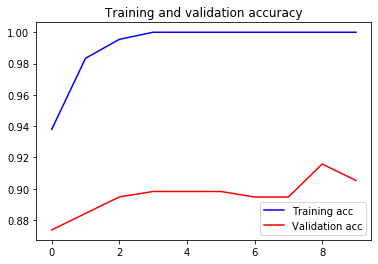

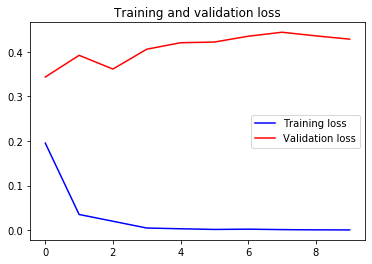

In [153]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [154]:
torch.save(model, './models/fine_tuned_transfer.pt')

In [ ]:
# stride > 1
# L2: optimizer = optim.Adam(bignet.parameters(), lr=hparams['learning_rate'], weight_decay=0.001) [canviar nom model]
# Dropout: nn.Dropout(p) después del flatten

In [ ]:
# Gaussian noise for data augmentation

In [ ]:
# Data augmentation audio

In [ ]:
'''
separar una tos en varias toses
resamplear -> cambiar la freq de muestreo
quitar tramos de silencio
precission, recall, sensitivity sobretot [CONFUSION MATRIX] -> que ningún positivo se cuele (min falso negativo)
'''